# Day 1, Session 2, MD workshop
### Dr. Michael Shirts, CU Boulder

###  Simulating at constant *temperature* rather than constant energy


Import some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's use a potential that has two wells, so we can see where it gets trapped.

In [2]:
# double well potential
def potential(x):
    pot = x**4 - 8*x**3 + 15*x**2
    return pot

def force(x):
    f = -(4*x**3 - 24*x**2 + 30*x)
    return f

# minumum is at 4.2247, where pot = -16.946938

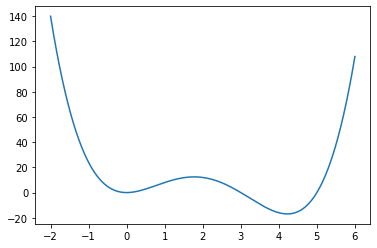

In [3]:
xlist = np.linspace(-2,6,1000)
plt.plot(xlist,potential(xlist))
plt.show()

We want the system to reach thermal equilibrium at a given temperature $T$, which means that the kinetic energy will be at the Maxwell-Boltzmann distribution.

First, we define a function generating a velocity from the Maxwell-Boltzmann distribution (in 1D).

In [5]:
k = 8.314 #  k in J/(K*mol)
def mb_dist(m,T):
    return np.sqrt(k*T/m)*np.random.normal()

First, we will use the simple procedure of randomize the velocities every $N$ steps from the Maxwell-Boltzmann distribution.  This is known as the Andersen thermostat ("thermo" - temperature, "stat" - keeps same).

Why might we not want to randomize every step?

In [6]:
def velocity_verlet(x,v,force,m=1,dt=1):
    
    # just the same as before
    v_h = v + 0.5*dt*(force(x)/m)  # half a step in x
    x = x + v_h*dt  # half a step in v
    v = v_h + 0.5*dt*(force(x)/m)

    return x,v

In [7]:
def do_some_anderson(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=6, T=50, freq=100):
    '''
    inputs: 
        nsteps = number of steps
        m = mass of particle
        dt = timestep length
        init_x, init_v = initial position and velocity
        T = temperature 
        freq = frequency (in number of steps) to randomize velocity
    output:
        results dictionary
    '''

    # we need to declare arrays to store data
    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    for i in range(nsteps):
        xnew,vnew = velocity_verlet(x,v,force,m=m,dt=dt)
        if i%freq==0:
            # randomize the particle velocity. This is the key point.
            vnew = mb_dist(m,T)
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        vold = v
        KEs[i] = 0.5*m*(0.5*(vs[i]+vold))**2
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

**Questions**:  

1. What happens if you run with very low frequency (i.e. no randomizations within the time period)
2. What happens if you run at higher frequency (randomizing every 100 steps)? 
3. What happens at lower and higher temperatures?

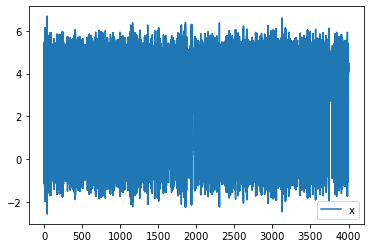

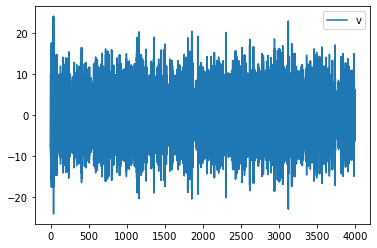

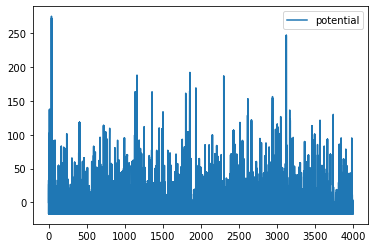

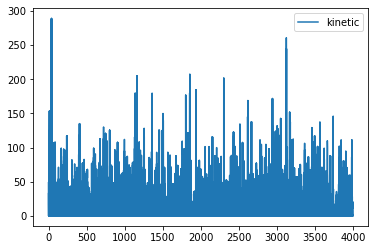

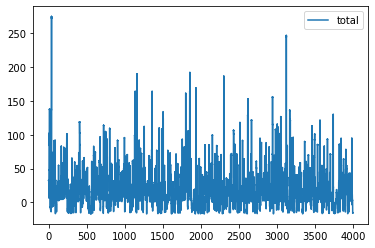

In [8]:
nsteps = 200000
dt = 0.02
T = 4

results = do_some_anderson(nsteps=nsteps,init_v=2, dt=dt,T=T,freq=100)

ts = dt*np.arange(nsteps)
plt.plot(ts,results['x'],label='x')

plt.legend()
plt.show()

plt.plot(ts,results['v'],label='v')
plt.legend()
plt.show()

plt.plot(ts,results['PE'],label="potential")
plt.legend()
plt.show()

plt.plot(ts,results['KE'],label="kinetic")
plt.legend()
plt.show()

plt.plot(ts,results['Total_E'],label='total')
plt.legend()
plt.show()

In [18]:
len(10*np.random.normal(size=len(ts)))

200000

**Question**: How can we test if we are doing the right thing?  One thing we know is that if it is thermal equilibrium, then $\langle KE \rangle = n/2 k_B T$, where $n$ is the number of degrees of freedom (DOF).  How many degrees of freedom are there in this case? How can we check the temperature? 

**Answer**: One degree of freedom, meaning that $T = 
    \frac{2}{k} \langle KE \rangle$.

In [412]:
    print("Ave KE = ", np.mean(results['KE']))
print("Estimated T=", (2/k)*np.mean(results['KE']))

Ave KE =  16.615411152722565
Estimated T= 3.996971650883465


We can also compute the free energy as a function of $x$, which because the system is just it's 1D, will also be the potential energy.  We can do this by computing $P(x)$, then finding $G(x) = -k_B T \ln P(x) = U(x)$.  Note that one can only find the free energy surface up to a constant, so we have to rescale to find the minimum. 

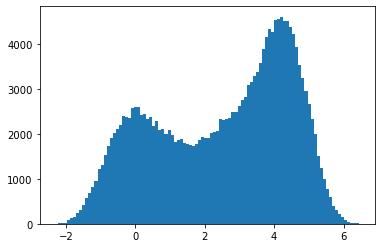

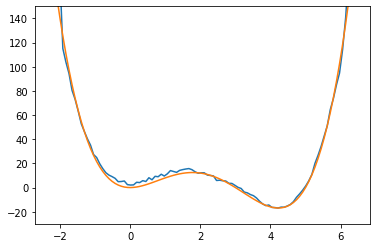

In [413]:
res = plt.hist(results['x'],bins=100)
plt.show()

bin_locs = 0.5*(res[1][1:]+res[1][:-1])
Effective_U = -k*T*np.log(res[0])
# shift it so it as the minimum at the same place
Shift_U = Effective_U - (np.min(Effective_U)-potential(4.2247))
plt.plot(bin_locs,Shift_U)
plt.plot(bin_locs,potential(bin_locs))
plt.ylim([-30,150])
plt.show()

What if instead of rerandomizing the force to a Maxwell-Boltzman distribution discretely, we added a bit of random forces each step, and removed that extra force by friction?  This is the Langevin equation, and we can implement that within the velocity verlet framework. 

In [414]:
def langevin(x,v,force,m=1,dt=1,tau=10,T=50):

    '''
    Inputs are the current x and v, 
    the force function, the mass, the timstep, a 
    timescale tau for adding more energy in / sucking it out 
    (can be thought of as an inverse of a friction, 
    and the temperature.

    '''
    v_h = v+0.5*dt*(force(x)/m)  # half a step in x
    x = x+0.5*v_h*dt  # half a step in v
    sig = (1-np.exp(-2*dt/tau))
    # sig = sqrt(J/kg) = m/s (units)
    a = np.exp(-dt/tau)
    b = np.sqrt(sig)
    v_h = a*v_h + b*mb_dist(m,T)  # randomize v
    x = x+0.5*v_h*dt # half a step in v
    v = v_h + 0.5*dt*force(x)/m  # half a step in x
    
    return x,v

**Exploration:** What happens at various temperatures with the Langevin integrator/thermostat?  How is similar to or different than the Langevin integrator/thermostat?

**Some Possible Answers**: 

In [415]:
def do_some_langevin(nsteps=100, m=1, dt=0.1, 
               init_x = 0, init_v=2,T=50):

    xs = np.zeros(nsteps)
    vs = np.zeros(nsteps)
    PEs = np.zeros(nsteps)
    KEs = np.zeros(nsteps)
    Es = np.zeros(nsteps)

    x = init_x
    v = init_v

    for i in range(nsteps):
        xnew,vnew = langevin(x,v,force,m=m,dt=dt,T=T)
        x = xnew
        v = vnew
        xs[i] = x
        vs[i] = v
        vold = v
        KEs[i] = 0.5*m*(0.5*(vs[i]+vold))**2
        PEs[i] = potential(x)
        Es[i] = PEs[i] + KEs[i]

    results = dict()
    results['x'] = xs
    results['v'] = vs
    results['KE'] = KEs
    results['PE'] = PEs
    results['Total_E'] = Es
    
    return results

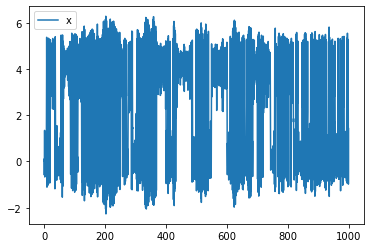

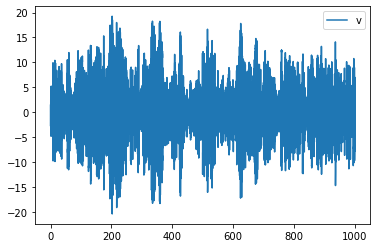

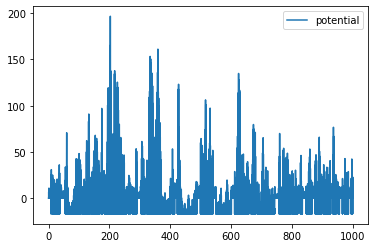

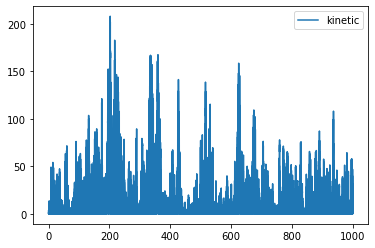

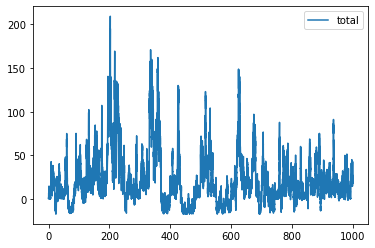

Ave KE =  18.11271669401538
Estimated T= 4.3571606192002355


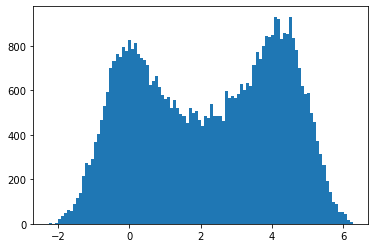

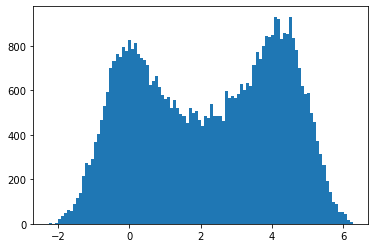

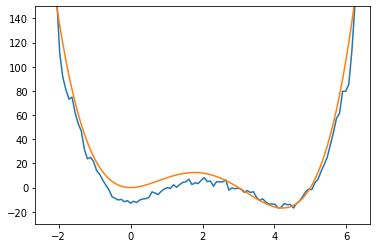

In [402]:
nsteps = 50000
dt = 0.02
T = 4

results= do_some_langevin(nsteps=nsteps, init_v=2, dt=dt,T=T)

ts = dt*np.arange(nsteps)
plt.plot(ts,results['x'],label='x')

plt.legend()
plt.show()

plt.plot(ts,results['v'],label='v')
plt.legend()
plt.show()

plt.plot(ts,results['PE'],label="potential")
plt.legend()
plt.show()

plt.plot(ts,results['KE'],label="kinetic")
plt.legend()
plt.show()

plt.plot(ts,results['Total_E'],label='total')
plt.legend()
plt.show()

print("Ave KE = ", np.mean(results['KE']))
print("Estimated T=", (2/k)*np.mean(results['KE']))

res = plt.hist(results['x'],bins=100)
plt.show()

res = plt.hist(results['x'],bins=100)
plt.show()

bin_locs = 0.5*(res[1][1:]+res[1][:-1])
Effective_U = -k*T*np.log(res[0])
# shift it so it as the minimum at the same place
Shift_U = Effective_U - (np.min(Effective_U)-potential(4.2247))
plt.plot(bin_locs,Shift_U)
plt.plot(bin_locs,potential(bin_locs))
plt.ylim([-30,150])
plt.show()